<h1>Predict strong autocorrelation time series with CNN<h1/>

midterm homework by: Lihong Ao, 2019271014, phisics, SZU.            advisor: Min Lu

In this tutorial, we use CNN to predict a stochastic strong autocorrelation time series, which main idea is classifying the first order diffrerncial of the historical data into categories, changing the problem into a classification problem. Let's experience the following steps now! \(^o^)/

<h2>Importing Needed packages</h2>

In [1]:
import numpy as np
import pandas as pd
import time
import requests
import json
import csv
import tflearn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_1d, max_pool_1d
from tflearn.layers.estimator import regression
from tflearn.data_utils import shuffle, to_categorical

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


<h2>1.Reading historical data from the website</h2>

The following 3 cells of code is modified from https://zhuanlan.zhihu.com/p/109021998. The evil time series we read foreshadows the scale of the human disaster. Human can be redempted only when the value of it staying low.

In [2]:
#The next 3 blocks of code is modified from https://zhuanlan.zhihu.com/p/109021998
time_stamp = int(time.time())
print(f"Now timestamp: {time_stamp}")
request_link = f"https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id=1&convertId=2781&timeStart=1480457600&timeEnd=1621728000"
print("Request link: " + request_link)
r = requests.get(url = request_link)

content = json.loads(r.content)
#print(type(content))
quoteList = content['data']['quotes']
#print(quoteList)

Now timestamp: 1621777392
Request link: https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id=1&convertId=2781&timeStart=1480457600&timeEnd=1621728000


<h2>2.Saving the historical data</h2>

In [3]:
# for windows, newline=''
with open('BTC.csv','w' ,encoding='utf8',newline='') as f:
    csv_write = csv.writer(f)
    csv_head = ["Date","Price","Volume"]
    csv_write.writerow(csv_head)

    for quote in quoteList:
        quote_date = quote["timeOpen"][:10]
        quote_price = "{:.2f}".format(quote["quote"]["close"])
        quote_volume = "{:.2f}".format(quote["quote"]["volume"])
        csv_write.writerow([quote_date, quote_price, quote_volume])

print("Done")

Done


<h2>3.Visualising and checking the historical data</h2>

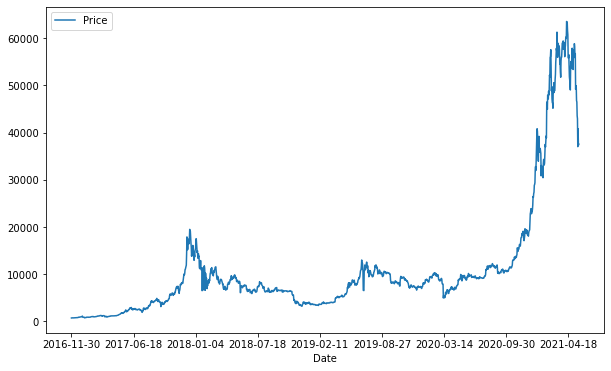

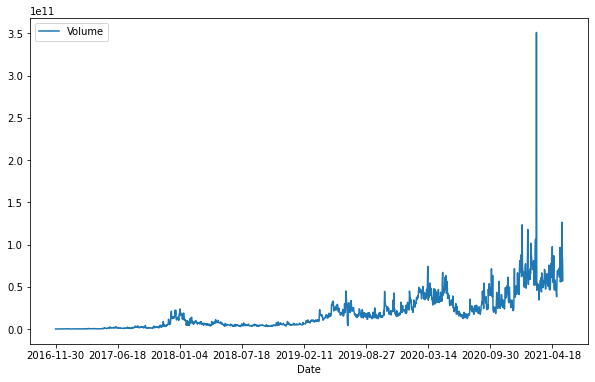

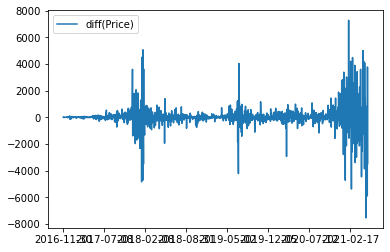

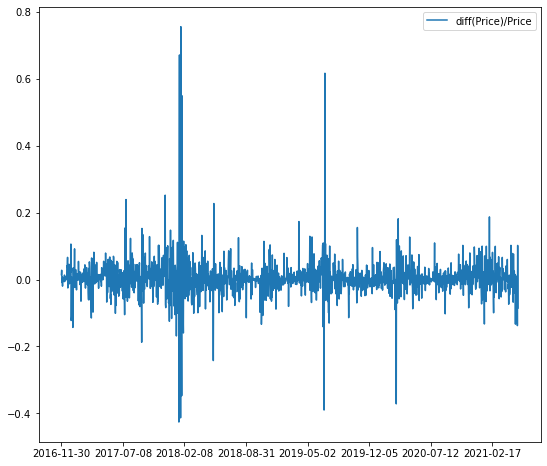

In [4]:

series = pd.DataFrame()
df = pd.read_csv("BTC.csv")
series['Date'] = df['Date'].tolist()
series['Price'] = df['Price'].tolist()
series['Volume'] = df['Volume'].tolist()
dprice=[]
dpriceRatio=[]
for i in range(1,len(series['Price'])-1):
    dprice.append(series['Price'][i]-series['Price'][i-1])
    dpriceRatio.append((series['Price'][i]-series['Price'][i-1])/series['Price'][i-1])
#print(series)
#print(dprice)
#print(dpriceRatio)

ax = plt.gca()
series.plot(kind='line', x='Date', y='Price', ax=ax,figsize=(10,6))
plt.show()

plt.cla()
ax = plt.gca()
series.plot(kind='line', x='Date', y='Volume', ax=ax,figsize=(10,6))
plt.show()

plt.plot(series['Date'].tolist()[0:len(dprice)],dprice)
plt.rcParams['figure.figsize'] = (9,8)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(220))
plt.legend(labels=['diff(Price)'],loc='best')
plt.show()

plt.plot(series['Date'].tolist()[0:len(dprice)],dpriceRatio)
plt.rcParams['figure.figsize'] = (9,8)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(220))
plt.legend(labels=['diff(Price)/Price'],loc='best')
plt.show()

<h2>4.Defining train, test and validation set with a user-define taxonomy</h2>

Divide the historical data into categories accroding to rate of increase (diff(Price)/Price). In this way, the prediction problem can be transfer into a classification problem.

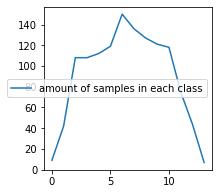

[ 12  53 132 134 134 158 184 176 161 149 140  93  60   8]
(1276, 20, 1)
(1276, 14)
(318, 20, 1)
(318, 14)


In [12]:
order=20
proportion_test=1/5
price=series['Price'].tolist()
count_test=int((len(price)-2*order)*proportion_test)     #taking 1/5 of the sample as the test set
train_price=[]
test_price=[]
train_verify_dpriceRatio=[]
test_verify_dpriceRatio=[]
#homogeneous classification of dpriceRatio (unrecommended):
"""def classify(x):
    class_num=20
    class_height=0.01    #class_height*class_num/2>x isn't permitted
    a=[0]*class_num
    a[np.ceil((x+class_height*class_num/2)/class_height).astype(int)]=1
    return(a)"""
#inhomogeneous classification of dpriceRatio:
num_section=14   # 1 + number of "if" below, other cells will use it again.
def classify(x):
    a=[0]*num_section
    if x<-0.14:
        a[0]=1
    elif -0.14<=x<-0.07:
        a[1]=1
    elif -0.07<=x<-0.036:
        a[2]=1
    elif -0.036<=x<-0.02:
        a[3]=1
    elif -0.02<=x<-0.01:
        a[4]=1
    elif -0.01<=x<-0.003:
        a[5]=1
    elif -0.003<=x<0.003:
        a[6]=1
    elif 0.003<=x<0.01:
        a[7]=1
    elif 0.01<=x<0.018:
        a[8]=1
    elif 0.018<=x<0.03:
        a[9]=1
    elif 0.03<=x<0.05:
        a[10]=1
    elif 0.05<=x<0.08:
        a[11]=1
    elif 0.08<=x<0.2:
        a[12]=1
    else:
        a[13]=1
    return(a)
eq_value=[-0.14,-0.115,-0.053,-0.028,-0.015,0,-0.065,0.014,0.024,0.04,0.065,0.14,0.2]   #eq_value is recomended to set as the mid value of each section.

for i in range(0,len(price)-2*order-1):      #defining train, test and validation set
    train_price.append(price[i:i+order])
    train_verify_dpriceRatio.append(classify(dpriceRatio[i+order+1]))
for i in range(1,count_test):
    test_price.append(train_price[int(i/proportion_test-i)])
    train_price.pop(int(i/proportion_test-i))
    test_verify_dpriceRatio.append(train_verify_dpriceRatio[int(i/proportion_test-i)])
    train_verify_dpriceRatio.pop(int(i/proportion_test-i))

train_price=np.expand_dims(np.array(train_price),axis=2)     #reshape
test_price=np.expand_dims(np.array(test_price),axis=2)
train_verify_dpriceRatio=np.array(train_verify_dpriceRatio)
test_verify_dpriceRatio=np.array(test_verify_dpriceRatio)

#adjusting the classification above accroding to the following figure, the distribution shouldn't be too concentrated.
plt.plot(sum(train_verify_dpriceRatio),fillstyle="full")
plt.rcParams['figure.figsize'] = (3,3)
plt.legend(labels=['amount of samples in each class'],loc='best')
plt.show()

print(sum(train_verify_dpriceRatio)+sum(test_verify_dpriceRatio))
#print(train_price)
#print(train_verify_dpriceRatio)
print(train_price.shape)
print(train_verify_dpriceRatio.shape)
print(test_price.shape)
print(test_verify_dpriceRatio.shape)

<h2>5.Training the model<h2/>

 A CNN model was built below with Tensorflow-tflearn. The output vector has the shape of (1, number of categories, 1). You must restart Jupyter kernel if you want to run the cell again.

In [6]:
#You must restart Jupyter kernel if you want to run the cell again.

#shuffle the input data to increase accuracy
train_price, train_verify_dpriceRatio = shuffle(train_price, train_verify_dpriceRatio)
train_verify_dpriceRatio = to_categorical(train_verify_dpriceRatio, num_section)
test_verify_dpriceRatio = to_categorical(test_verify_dpriceRatio, num_section)
#define the model
network = input_data(shape=[None ,order,1], name='input')
network = conv_1d(network, 30, 5, activation='relu', regularizer="L2")
network = conv_1d(network, 30, 5, activation='relu', regularizer="L2")
network = max_pool_1d(network, 2)
network = conv_1d(network, 60, 5, activation='relu', regularizer="L2")
network = conv_1d(network, 60, 5, activation='relu', regularizer="L2")
network = max_pool_1d(network, 2)
network = fully_connected(network, 512, activation='softmax')
network = dropout(network, 0.5)
network = fully_connected(network, num_section, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target')
model = tflearn.DNN(network, tensorboard_verbose=0)
#fit the model
model.fit(train_price,train_verify_dpriceRatio, n_epoch=50, shuffle=True, validation_set=(test_price, test_verify_dpriceRatio), show_metric=True)


Training Step: 999  | total loss: 0.28285 | time: 0.118s
| Adam | epoch: 050 | loss: 0.28285 - acc: 0.9251 -- iter: 1216/1276
Training Step: 1000  | total loss: 0.27212 | time: 1.128s
| Adam | epoch: 050 | loss: 0.27212 - acc: 0.9295 | val_loss: 0.26189 - val_acc: 0.9277 -- iter: 1276/1276
--


<h2>6.Using the model function to predict<h2/>

For the above model, the output is a vector which dimension is the number of categories (num_section). Maximum element of the output vector's position corresponds to an eq_value, which is considered to be the most probable result of the next step. 

Commonly, it doesn't mean much anymore if steps of predict (predict_steps as below) is set too large. Because after many steps predict by the method above, the output vector would be equalized. Requesting real-time historical data to update the model and paying attention to the first or second steps of predict is reasonable.

[32082.0334, 27590.548724, 23727.87190264, 20405.9698362704, 17549.134059192544, 15092.255290905587, 12979.339550178804, 11162.23201315377, 9599.519531312242, 8255.586796928528]


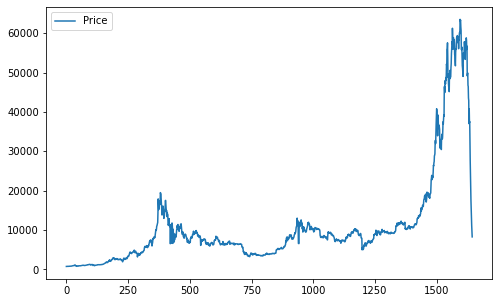

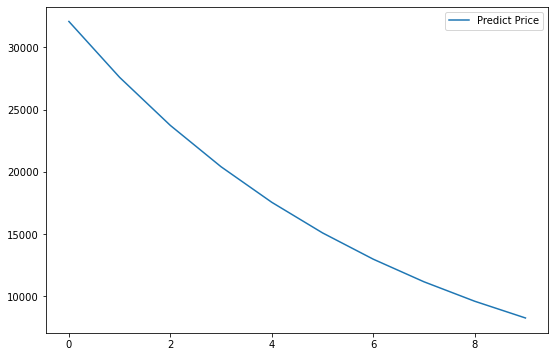

In [9]:
predict_steps = 10    #Warning: It's inaccuate to predict to many steps, <order/3 is recomended
Input = np.expand_dims((np.array(price[-order-1:-1])),axis=1)
Predict = (model.predict(np.expand_dims(Input,axis=0))).tolist()
max_index = Predict[0].index(max(Predict[0]))
price_predict=[price[-order:-1][-1]*(1+eq_value[max_index])]
for i in range(0,predict_steps-1):
    max_index = Predict[0].index(max(Predict[0]))
    previous = price[-order+i:-1]
    Input = np.expand_dims(previous+price_predict,axis=1)
    Predict = (model.predict(np.expand_dims(Input,axis=0))).tolist()
    price_predict.append(price_predict[-1]*(1+eq_value[max_index]))

#print(Predict)
print(price_predict)

plt.plot(price+price_predict,fillstyle="full")
plt.rcParams['figure.figsize'] = (9,6)
plt.legend(labels=['Price'],loc='best')
plt.show()

#In the next figure, only the first or second steps of predict is accurate enough.
plt.plot(price_predict,fillstyle="full")
plt.rcParams['figure.figsize'] = (8,5)
plt.legend(labels=['Predict Price'],loc='best')
plt.show()

<h2>Conclusion<h2/>

This tutorial classifies the first order diffrerncial of the historical data into categories and use CNN to predict a stochastic strong autocorrelation time series. With 50 epoches of training, accuracy is up to 0.9295, total loss decreases to 0.28285

#### Reference

1.https://zhuanlan.zhihu.com/p/109021998

2.http://tflearn.org/

3.http://c.biancheng.net/view/1930.html

4.https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_mnist.py

5.https://www.kaggle.com/